# Insurance Fraud Claims Detection

In this notebook, I'm going to engineer the variables of **Auto Insurance Claims Data** on Kaggle. 

To engineer the variables We need to tackle:

1. Missing values: Assess missing in ['collision_type', 'property_damage', 'police_report_available']
2. Target variable: Encoding
3. Numerical variables:
    - Discrete variables: Assess umbrella_limit and policy_deductable variables
    - Continuous variables: Binning Age, policy_annual_premium and month_as_customer
4. Outliers (not now)
5. Categorical variables: Binning and Encoding
6. Standarise the values of the variables to the same range

## Libraries and Environments

In [132]:
# Data Sciences

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Plot

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Utils
import os
import pprint

# Set notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.simplefilter(action='ignore')

In [133]:
raw = '../data/raw/insurance_claims.csv'
interim = '../data/interim/'
processed= '../data/processed/'
models= '../models/'

## Data Ingestion

### Read data

In [134]:
data = pd.read_csv(raw)
print(data.shape)
data.head()

(1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
months_as_customer             1000 non-null int64
age                            1000 non-null int64
policy_number                  1000 non-null int64
policy_bind_date               1000 non-null object
policy_state                   1000 non-null object
policy_csl                     1000 non-null object
policy_deductable              1000 non-null int64
policy_annual_premium          1000 non-null float64
umbrella_limit                 1000 non-null int64
insured_zip                    1000 non-null int64
insured_sex                    1000 non-null object
insured_education_level        1000 non-null object
insured_occupation             1000 non-null object
insured_hobbies                1000 non-null object
insured_relationship           1000 non-null object
capital-gains                  1000 non-null int64
capital-loss                   1000 non-null int64
incident_date    

### Preprocessing

In [136]:
# For semplicity I'll drop some variables.They required futhers analysis.

target = 'fraud_reported'
variables = [col for col in data.columns if col != target]

drop = ['policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 
        'insured_zip', 'insured_occupation', 'incident_date', 
        'insured_education_level', 'insured_relationship', 'injury_claim', 'property_claim', 'vehicle_claim', 
        'incident_state', 'incident_city', 'incident_location', 'auto_model', 'auto_make', 'auto_year', '_c39']

data.drop(drop, axis=1, inplace=True)

In [137]:
# I rename variable names with '-'

data.rename(columns={"capital-gains": "capital_gains", "capital-loss": "capital_loss"}, inplace=True)

In [138]:
# I drop anomalies 

print(data['umbrella_limit'].value_counts(), '\n')
data = data[data['umbrella_limit']>=0]
print(data['umbrella_limit'].value_counts(), '\n')

 0           798
 6000000      57
 5000000      46
 4000000      39
 7000000      29
 3000000      12
 8000000       8
 9000000       5
 2000000       3
 10000000      2
-1000000       1
Name: umbrella_limit, dtype: int64 

0           798
6000000      57
5000000      46
4000000      39
7000000      29
3000000      12
8000000       8
9000000       5
2000000       3
10000000      2
Name: umbrella_limit, dtype: int64 



In [139]:
# Missing values
# Assess missing in 'collision_type', 'property_damage' and 'police_report_available'
missing_predictors = [col for col in data.select_dtypes(include='object').columns if any(data[col].str.contains('?', regex=False))]

for var in missing_predictors:
    print(var)
    print(data[var].value_counts(), '\n')

collision_type
Rear Collision     292
Side Collision     275
Front Collision    254
?                  178
Name: collision_type, dtype: int64 

property_damage
?      360
NO     338
YES    301
Name: property_damage, dtype: int64 

police_report_available
NO     343
?      342
YES    314
Name: police_report_available, dtype: int64 



**Comment**: We may replace it with 'Missing' string

In [140]:
data[missing_predictors] = data[missing_predictors].replace('?', 'missing')

In [141]:
# Check
for var in missing_predictors:
    data_missing = any(data[var].str.contains('?', regex=False))
print(data_missing)

False


In [142]:
data.to_csv(interim + '0_data.csv', index=False)

In [143]:
# Train and Test Split

predictors = [col for col in data.columns if col != target]

X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['fraud_reported'], 
                                                    test_size=0.10, 
                                                    random_state=1) # ALWAYS set random seed for reproducibility!
X_train.shape, X_test.shape

((899, 20), (100, 20))

In [144]:
X_train.to_csv(interim + '1_X_train_base.csv', index=False)
X_test.to_csv(interim + '1_X_test_base.csv', index=False)
y_train.to_csv(interim + '1_y_train_base.csv', index=False)
y_test.to_csv(interim + '1_y_test_base.csv', index=False)

## Feature Engineering

### Target Variable

In [145]:
y_train.unique()

array(['N', 'Y'], dtype=object)

In [146]:
target_categories = {'Y': 1, 'N': 0}

y_train = y_train.map(target_categories).astype('category')
y_test = y_test.map(target_categories).astype('category')

print(y_train.cat.categories)
print(y_train.value_counts()/len(y_train))
print()
print(y_test.cat.categories)
print(y_test.value_counts()/len(y_test))

Int64Index([0, 1], dtype='int64')
0    0.74861
1    0.25139
Name: fraud_reported, dtype: float64

Int64Index([0, 1], dtype='int64')
0    0.79
1    0.21
Name: fraud_reported, dtype: float64


In [147]:
y_train.to_csv(processed + 'y_train_imputed.csv', header=['y_train'], index=False)
y_test.to_csv(processed + 'y_test_imputed.csv', header=['y_test'], index=False)

### Numerical variables

In [148]:
# numerical
numerical_predictors = [col for col in predictors if X_train[col].dtypes != 'object']
discrete_predictors = [col for col in numerical_predictors if len(X_train[col].unique()) < 30]
continuous_predictors = [col for col in numerical_predictors if col not in discrete_predictors]

<!-- #### Time variables
time_predictors = [
    col for col in predictors if 'year' in col or 'date' in col]
# time_to_incident_months
# data[time_predictors].info()

# for var in time_predictors:
#     if var == 'auto_year':
#     df[var] = pd.to_datetime(df[var], format='%Y')
#         pass
#     else:
#         data[var] = pd.to_datetime(data[var])
        
# print(data[time_predictors].info())

# def time_monthly_incident(data, var):
#     # Time difference
#     data['time_to_incident'] = data[var] - data['policy_bind_date']
#     data['time_to_incident_days'] = data['time_to_incident'].dt.days
#     # Monthly-based difference
#     data['time_to_incident_months'] = round(data['time_to_incident_days'] / 30, 0)
#     # Negative differences has no sense
#     flt_time = data['time_to_incident_months'] > 0
#     #Drop date variables
#     data.drop([var, 'policy_bind_date', 'time_to_incident', 'time_to_incident_days'], axis=1, inplace=True)
#     return data[flt_time]

# data = time_monthly_incident(data, 'incident_date')

# data.shape

# data.to_csv(interim + '2_data_time.csv', index=False) -->

#### Discrete Variables

In [149]:
X_train[discrete_predictors].head()

,policy_deductable,umbrella_limit,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses
336,500,4000000,14,3,2,1
13,1000,0,5,1,1,1
872,1000,0,23,3,0,0
156,2000,0,10,3,2,1
429,2000,0,2,1,2,3


**policy_decuctable**

In [150]:
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

X_train['policy_deductable_groups'] = pd.cut(X_train['policy_deductable'], bins = bins, labels = bin_labels, include_lowest = True)
X_train.drop('policy_deductable', axis=1, inplace=True)

X_test['policy_deductable_groups'] = pd.cut(X_test['policy_deductable'], bins = bins, labels = bin_labels, include_lowest = True)
X_test.drop('policy_deductable', axis=1, inplace=True)

print(X_train['policy_deductable_groups'].value_counts(), '\n')
print()

501-1000     314
0-500        301
1501-2000    284
1001-1500      0
Name: policy_deductable_groups, dtype: int64 




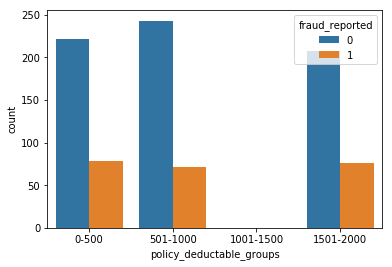

In [151]:
sns.countplot(x=X_train['policy_deductable_groups'], hue=y_train);

In [152]:
X_train.to_csv(interim + '3_X_train_policy_deductable.csv', index=False)
X_test.to_csv(interim + '3_X_test_policy_deductable.csv', index=False)

#### Continuous Variables

In [153]:
X_train[continuous_predictors].head()

,months_as_customer,age,policy_annual_premium,capital_gains,capital_loss,total_claim_amount
336,176,39,1365.46,0,-56600,44280
13,121,34,936.61,52800,-32800,7280
872,290,45,1311.30,38500,0,52650
156,461,61,1402.75,0,0,72100
429,467,58,977.40,82200,0,55700


**Age**

In [154]:
X_train['age'].describe()

count    899.000000
mean      38.913237
std        9.152216
min       19.000000
25%       32.000000
50%       38.000000
75%       44.000000
max       64.000000
Name: age, dtype: float64

In [155]:
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]

X_train['age_groups'] = pd.cut(X_train['age'], bins = bins, labels = bin_labels, include_lowest = True)
X_train.drop('age', axis=1, inplace=True)

X_test['age_groups'] = pd.cut(X_test['age'], bins = bins, labels = bin_labels, include_lowest = True)
X_test.drop('age', axis=1, inplace=True)

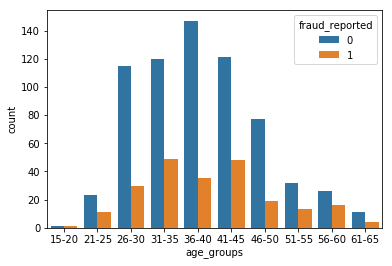

In [156]:
sns.countplot(x=X_train['age_groups'], hue=y_train);

In [157]:
X_train.to_csv(interim + '3_X_train_age.csv', index=False)
X_test.to_csv(interim + '3_X_test_age.csv', index=False)

**policy_annual_premium**

In [158]:
X_train['policy_annual_premium'].describe()

count     899.000000
mean     1251.037086
std       244.107876
min       433.330000
25%      1082.230000
50%      1252.080000
75%      1411.365000
max      2047.590000
Name: policy_annual_premium, dtype: float64

In [159]:
bins = list(np.linspace(0, 2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

X_train['policy_annual_premium_groups'] = pd.cut(X_train['policy_annual_premium'], bins = bins, labels=bin_labels, include_lowest = True)
X_train.drop('policy_annual_premium', axis=1, inplace=True)

X_test['policy_annual_premium_groups'] = pd.cut(X_test['policy_annual_premium'], bins = bins, labels=bin_labels, include_lowest = True)
X_test.drop('policy_annual_premium', axis=1, inplace=True)

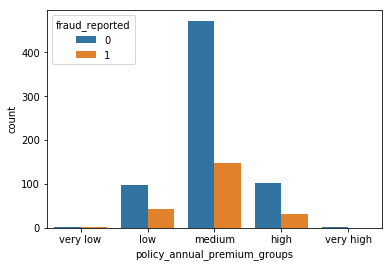

In [160]:
sns.countplot(x=X_train["policy_annual_premium_groups"], hue=y_train);

In [161]:
X_train.to_csv(interim + '4_X_train_annual_prem.csv', index=False)
X_test.to_csv(interim + '4_X_test_annual_prem.csv', index=False)

<!-- # capital net
# data['capital_net'] = abs(data['capital_gains'] - data['capital_loss'])
# data.drop(['capital_gains', 'capital_loss'], axis=1, inplace=True)
# sns.distplot(data[data['fraud_reported']==0]['capital_net'], kde=False);
# sns.distplot(data[data['fraud_reported']==1]['capital_net'], kde=False);
# data.to_csv(interim + '6_data_capital_net.csv', index=False) -->

**months_as_customer**

In [162]:
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

X_train['months_as_customer_groups'] = pd.cut(X_train['months_as_customer'], bins = bins, labels = bin_labels, include_lowest= True)
X_train.drop(['months_as_customer'], axis=1, inplace=True)

X_test['months_as_customer_groups'] = pd.cut(X_test['months_as_customer'], bins = bins, labels = bin_labels, include_lowest= True)
X_test.drop(['months_as_customer'], axis=1, inplace=True)

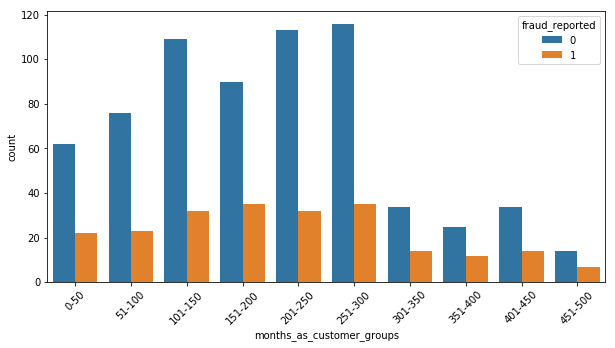

In [163]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x=X_train["months_as_customer_groups"], hue=y_train);
fig.set_xticklabels(fig.get_xticklabels(), rotation=45);


In [164]:
X_train.to_csv(interim + '5_X_train_months_as_customer.csv', index=False)
X_test.to_csv(interim + '5_X_test_months_as_customer.csv', index=False)

### Categorical Variables

In [165]:
# non numerical
categorical_predictors = [col for col in X_train.columns if X_train[col].dtypes != 'int' and col != target]
ordinal_predictors = ['incident_severity', 'policy_annual_premium_groups', 'policy_deductable_groups']
nominal_predictors = [col for col in categorical_predictors if col not in ordinal_predictors]

In [166]:
X_train[categorical_predictors].head()

,insured_sex,insured_hobbies,incident_type,collision_type,incident_severity,authorities_contacted,property_damage,police_report_available,policy_deductable_groups,age_groups,policy_annual_premium_groups,months_as_customer_groups
336,MALE,sleeping,Multi-vehicle Collision,Side Collision,Minor Damage,Fire,NO,NO,0-500,36-40,medium,151-200
13,FEMALE,bungie-jumping,Parked Car,missing,Minor Damage,None,NO,NO,501-1000,31-35,low,101-150
872,FEMALE,chess,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,YES,YES,501-1000,41-45,medium,251-300
156,MALE,exercise,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,missing,YES,1501-2000,61-65,medium,451-500
429,MALE,bungie-jumping,Single Vehicle Collision,Front Collision,Total Loss,Fire,YES,NO,1501-2000,56-60,low,451-500


#### Nominal

In [167]:
X_train[nominal_predictors].head()

,insured_sex,insured_hobbies,incident_type,collision_type,authorities_contacted,property_damage,police_report_available,age_groups,months_as_customer_groups
336,MALE,sleeping,Multi-vehicle Collision,Side Collision,Fire,NO,NO,36-40,151-200
13,FEMALE,bungie-jumping,Parked Car,missing,None,NO,NO,31-35,101-150
872,FEMALE,chess,Multi-vehicle Collision,Side Collision,Ambulance,YES,YES,41-45,251-300
156,MALE,exercise,Multi-vehicle Collision,Rear Collision,Police,missing,YES,61-65,451-500
429,MALE,bungie-jumping,Single Vehicle Collision,Front Collision,Fire,YES,NO,56-60,451-500


In [168]:
X_train['insured_hobbies']

336          sleeping
13     bungie-jumping
872             chess
156          exercise
429    bungie-jumping
824          kayaking
267       video-games
539            hiking
236              golf
944            movies
480          sleeping
785         cross-fit
950       video-games
59           kayaking
868             chess
175       board-games
711      base-jumping
450      base-jumping
120       board-games
894            movies
180        basketball
312         skydiving
3         board-games
194        basketball
438          sleeping
683             chess
886          exercise
620             chess
652          yachting
692         paintball
552             chess
248              golf
659       video-games
2         board-games
975              polo
812         cross-fit
862    bungie-jumping
857           reading
359        basketball
769            movies
73               golf
117          exercise
938          exercise
536        basketball
111           dancing
510       

In [169]:
# **insured_hobbies**
replace_labels = [label for label in X_train['insured_hobbies'].unique() if label not in ['chess', 'cross-fit']]
X_train['insured_hobbies'] = X_train['insured_hobbies'].replace(replace_labels, 'others')
X_test['insured_hobbies'] = X_test['insured_hobbies'].replace(replace_labels, 'others')

In [170]:
X_train = pd.get_dummies(X_train, columns=nominal_predictors)
X_test = pd.get_dummies(X_test, columns=nominal_predictors)

In [171]:
X_train.to_csv(interim + '6_X_train_dummies.csv', index=False)
X_train.to_csv(interim + '6_X_test_dummies.csv', index=False)

#### Ordinal

In [172]:
X_train[ordinal_predictors].head()

,incident_severity,policy_annual_premium_groups,policy_deductable_groups
336,Minor Damage,medium,0-500
13,Minor Damage,low,501-1000
872,Major Damage,medium,501-1000
156,Minor Damage,medium,1501-2000
429,Total Loss,low,1501-2000


In [173]:
ord_categories = {col: list(X_train[col].unique()) for col in ordinal_predictors}
ord_categories

{'incident_severity': ['Minor Damage',
  'Major Damage',
  'Total Loss',
  'Trivial Damage'],
 'policy_annual_premium_groups': ['medium',
  'low',
  'high',
  'very low',
  'very high'],
 'policy_deductable_groups': ['0-500', '501-1000', '1501-2000']}

In [174]:
incident_severity_categories = pd.Categorical(X_train[ordinal_predictors]['incident_severity'],
                                              categories=['Trivial Damage',
                                                          'Minor Damage',
                                                          'Major Damage',
                                                          'Total Loss'],
                                              ordered=True)

policy_annual_premium_categories = pd.Categorical(X_train[ordinal_predictors]['policy_annual_premium_groups'],
                                                  categories=['very low',
                                                          'low',
                                                          'medium',
                                                          'high',
                                                          'very high'],
                                                  ordered=True)

# policy_csl_categories = pd.Categorical(data[ordinal_predictors]['policy_csl'],
#                                        categories=['100/300', '250/500', '500/1000'],
#                                        ordered=True)

policy_deductable_categories = pd.Categorical(X_train[ordinal_predictors]['policy_deductable_groups'],
                                       categories=['0-500', '501-1000', '1001-1500', '1501-2000'],
                                       ordered=True)

In [175]:
categories = [policy_annual_premium_categories, incident_severity_categories, policy_deductable_categories]

for var, cat in zip(ord_categories, categories):
    labels, unique = pd.factorize(cat, sort=True)
    X_train[var] = labels

In [176]:
incident_severity_categories = pd.Categorical(X_test[ordinal_predictors]['incident_severity'],
                                              categories=['Trivial Damage',
                                                          'Minor Damage',
                                                          'Major Damage',
                                                          'Total Loss'],
                                              ordered=True)

policy_annual_premium_categories = pd.Categorical(X_test[ordinal_predictors]['policy_annual_premium_groups'],
                                                  categories=['very low',
                                                          'low',
                                                          'medium',
                                                          'high',
                                                          'very high'],
                                                  ordered=True)

# policy_csl_categories = pd.Categorical(data[ordinal_predictors]['policy_csl'],
#                                        categories=['100/300', '250/500', '500/1000'],
#                                        ordered=True)

policy_deductable_categories = pd.Categorical(X_test[ordinal_predictors]['policy_deductable_groups'],
                                       categories=['0-500', '501-1000', '1001-1500', '1501-2000'],
                                       ordered=True)

In [177]:
categories = [policy_annual_premium_categories, incident_severity_categories, policy_deductable_categories]

for var, cat in zip(ord_categories, categories):
    labels, unique = pd.factorize(cat, sort=True)
    X_test[var] = labels

In [178]:
X_train.head()

,umbrella_limit,capital_gains,capital_loss,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,policy_deductable_groups,policy_annual_premium_groups,insured_sex_FEMALE,insured_sex_MALE,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_others,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,collision_type_missing,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,property_damage_NO,property_damage_YES,property_damage_missing,police_report_available_NO,police_report_available_YES,police_report_available_missing,age_groups_15-20,age_groups_21-25,age_groups_26-30,age_groups_31-35,age_groups_36-40,age_groups_41-45,age_groups_46-50,age_groups_51-55,age_groups_56-60,age_groups_61-65,months_as_customer_groups_0-50,months_as_customer_groups_51-100,months_as_customer_groups_101-150,months_as_customer_groups_151-200,months_as_customer_groups_201-250,months_as_customer_groups_251-300,months_as_customer_groups_301-350,months_as_customer_groups_351-400,months_as_customer_groups_401-450,months_as_customer_groups_451-500
336,4000000,0,-56600,2,14,3,2,1,44280,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
13,0,52800,-32800,1,5,1,1,1,7280,1,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
872,0,38500,0,2,23,3,0,0,52650,1,2,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
156,0,0,0,2,10,3,2,1,72100,2,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
429,0,82200,0,1,2,1,2,3,55700,2,3,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [179]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899 entries, 336 to 37
Data columns (total 55 columns):
umbrella_limit                            899 non-null int64
capital_gains                             899 non-null int64
capital_loss                              899 non-null int64
incident_severity                         899 non-null int64
incident_hour_of_the_day                  899 non-null int64
number_of_vehicles_involved               899 non-null int64
bodily_injuries                           899 non-null int64
witnesses                                 899 non-null int64
total_claim_amount                        899 non-null int64
policy_deductable_groups                  899 non-null int64
policy_annual_premium_groups              899 non-null int64
insured_sex_FEMALE                        899 non-null uint8
insured_sex_MALE                          899 non-null uint8
insured_hobbies_chess                     899 non-null uint8
insured_hobbies_cross-fit               

In [180]:
X_train.to_csv(interim + '7_X_train_ordinal.csv', index=False)
X_test.to_csv(interim + '7_X_test_ordinal.csv', index=False)

## Features Scaling

In [181]:
# create scaler
scaler = MinMaxScaler()

#  fit the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set
X_train[:] = scaler.transform(X_train[:])
X_test[:] = scaler.transform(X_test[:])

In [182]:
X_train.to_csv(processed + 'X_train_final.csv', index=False)
X_test.to_csv(processed + 'X_test_final.csv', index=False)

## Final comment

At the end, I get 55 predictors for training the model